<a href="https://colab.research.google.com/github/Pulin98/Statistical-Learning-and-Neural-Network/blob/main/Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**STATISTICAL LEARNING AND NEURAL NETWORKS, A.A. 2022/2023**

*   Voce elenco
*   Voce elenco



**COMPUTER LAB 4** - Kalman filter

**Duration: 3 hours**

**Introduction:**

In this lab, you are provided with the set of coordinates (x,y – horizontal and vertical) describing the trajectories of pedestrians moving acrooss a scene. Your task is to simulate the observed positions of the pedestrians by adding observation noise, then to track the subjects using a Kalman filter. In other words, you need to estimate the next (x,y) positions, from the observations of the previous positions.


*Simulating the observed coordinates*

Choose one of the trajectories in the dataset. This data will be considered the real trajectory. Generate the observed directory by adding observation noise $\delta_t\sim\mathcal{N}(0,\sigma^{2}_{R})$ to the (x,y) coordinates.


*Designing the Kalman filter*

Your task is to **design a Kalman filter** based on a constant velocity model, which tracks the next (x,y) position of the object, from the observation of the previous positions. The code must be based on the following model.

*   The state vector contains coordinates and velocities: $z^{T}_{t} = (z_{1t}, z_{2t}, v_{1t}, v_{2t})$ (see slides). The object has initial coordinates (0,0) and velocity $(\Delta,\Delta)$.
*   Only the coordinates (but not the velocities) are observed. This leads to a linear dynamical system with:

$A = \left( \begin{matrix} 1 & 0 & \Delta & 0 \\ 0 & 1 & 0 & \Delta \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{matrix} \right)$


$C = \left( \begin{matrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \end{matrix} \right)$

and B = D = 0.

*   $\Sigma_{Q}$, and $\Sigma_{R}$ should be set to:

$\Sigma_{Q} = \sigma^{2}_{Q}\left( \begin{matrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{matrix} \right)$

$\Sigma_{R} = \sigma^{2}_{R}\left( \begin{matrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{matrix} \right)$

To see if your Kalman filter is working well, you should plot the estimated position of the object over time with respect to the true position (i.e., the first two entries of the state vector) and the observed position. Depending on the chosen parameters, for each coordinate the graph may look something like this:

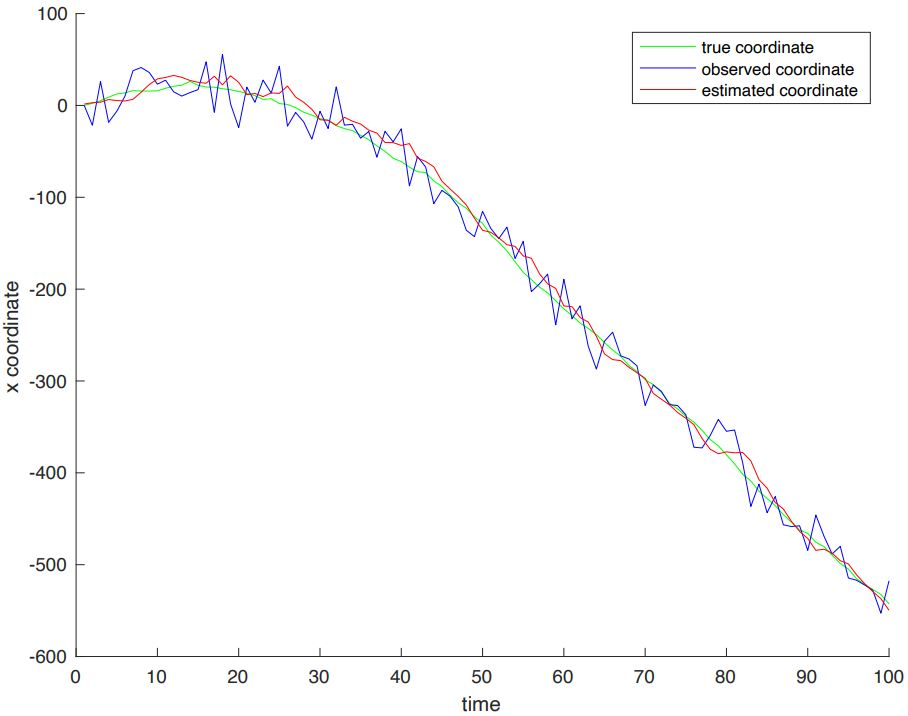

**Suggestion**: when implementing your Kalman filter, you will have to choose initial values for **$\mu_{t}$** and **$\Sigma_{t}$**. Provided that you do not make very unreasonable assumptions, the Kalman filter will update those estimates from observed data, so the initial choices are not very critical.

Test your Kalman filter modifying the values of some of the parameters, including standard deviations **$\sigma_{Q}$** and **$\sigma_{R}$**, initial values for **$\mu_{t}$** and **$\Sigma_{t}$** and the value of **$\Delta$**.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install ndjson

Mounted at /content/drive


In [ ]:
import ndjson
import pandas as pd
import numpy as np

#Dataset origin: https://paperswithcode.com/dataset/trajnet-1
#The crowds_students001 file is loaded, and formatted as a list of numpy vectors

with open('/content/drive/MyDrive/Colab Notebooks 2023 2024/Lab4/crowds_students001_trackonly.ndjson') as f:
  data = ndjson.load(f)

p='-1'

person_dict = []

for ii in range(len(data)):
  if(p!=data[ii]['track']['p']):
    p=data[ii]['track']['p']
    person_dict.append([])
  person_dict[p].append((data[ii]['track']['x'],data[ii]['track']['y']))

person_dict_numpy = []
for ii in range(148):
  person_dict_numpy.append(np.array(person_dict[ii], dtype=float))

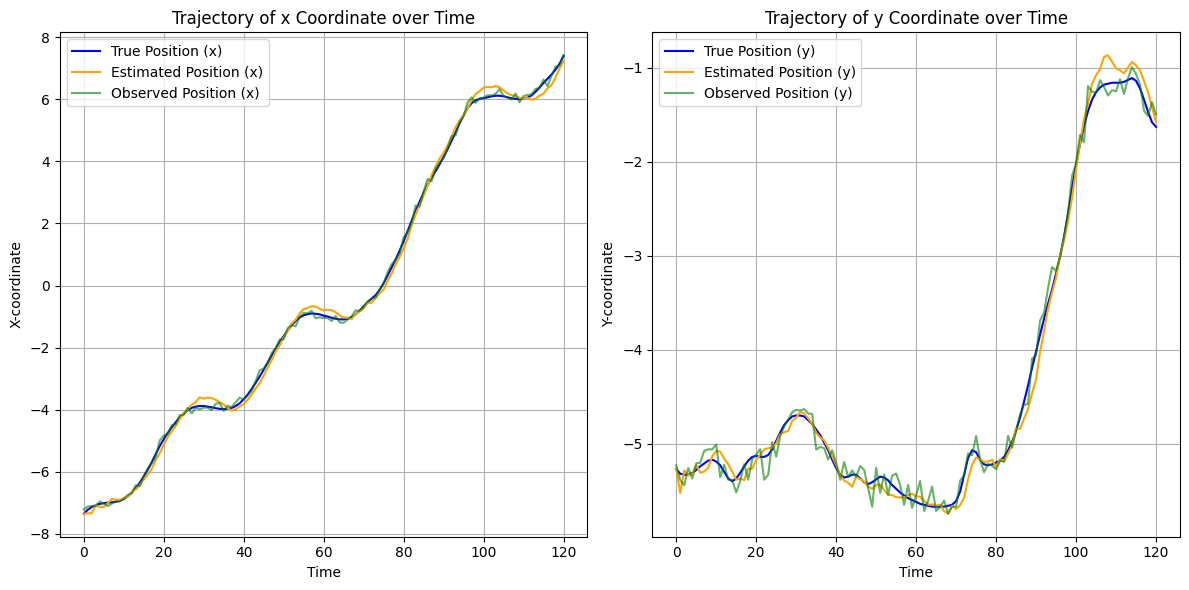

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Implement the kalman filter as a function using the numpy library, the matrix products can be done using the np.dot function
# The matrix inversion can be done using the np.linalg.inv

def kalman_filter(y, mu_tmin1, sigma_tmin1, A, C, Q, R):
  # Predict the state at the next time step

  mu_pred = np.dot(A, mu_tmin1)
  sigma_pred = np.dot(np.dot(A, sigma_tmin1), A.T) + Q
  y_hat = np.dot(C,mu_pred)

  # Calculate the Kalman gain

  K = np.dot(np.dot(sigma_pred, C.T), np.linalg.inv(np.dot(np.dot(C, sigma_pred), C.T) + R))

  # Update the estimate of the state

  r = y - y_hat
  mu_est = mu_pred + np.dot(K,r)
  I = np.identity(4)
  sigma_est = np.dot((I-np.dot(K,C)), sigma_pred)

  return mu_est, sigma_est

true_positions = person_dict_numpy[100] #choose a single trajectory by taking an element of the list person_dict_numpy, select a random index between 0 and 148


#Define parameter delta
Delta = 1.0

A = np.array([[1, 0, Delta, 0],
             [0, 1, 0, Delta],
             [0, 0, 1, 0 ],
             [0, 0, 0, 1 ]])


# Define the measurement matrix
C = np.array([[1, 0, 0, 0],  # x is measured directly
              [0, 1, 0, 0]]) # y is measured directly

# Set the standard deviation of the measurement noise

sigma_R = 0.1
sigma_Q = 0.01

# Define the process noise covariance matrix
Q = (sigma_Q**2)*np.eye(4)

# Define the measurement noise covariance matrix
R = (sigma_R**2)*np.eye(2)

# Set the initial state and covariance

mu_0 = np.concatenate([true_positions[0], np.array([0, 0])])  # Use the first observed position and assume initial velocities are zero
initial_covariance = 10 * np.eye(4)  # Initialize with a larger covariance matrix

sigma_0 = initial_covariance

# Initialize arrays to store results
mu_estimates = [mu_0]
sigma_estimates = [sigma_0]

# Iterate over the observed coordinates

for t in range(1,len(true_positions)):
  # Get the observed coordinates at time t
  # Note: the observed position is simulated by adding gaussian noise to the true_positions
  y = true_positions[t] + np.random.normal(0,sigma_R,2)

  #apply the kalman filter on the observed coordinates
  mu_tmin1 = mu_estimates[-1]
  sigma_tmin1 = sigma_estimates[-1]
  mu_est, sigma_est = kalman_filter(y, mu_tmin1, sigma_tmin1, A, C, Q, R)

  # Store results
  mu_estimates.append(mu_est)
  sigma_estimates.append(sigma_est)

# Convert results to NumPy arrays for easier manipulation
mu_estimates = np.array(mu_estimates)
sigma_estimates = np.array(sigma_estimates)

#Use the matplotlib library to plot the true positions, observed positions y and the results of the kalman filtering
#You should obtain a plot which resembles the one in the figure
#Plot the trajectory of the x coordinate over time and the trajectory of the y coordinate over time into two separate plot

# Plotting results
plt.figure(figsize=(12, 6))

# Plot the trajectory of the x coordinate over time
plt.subplot(1, 2, 1)
plt.grid()
plt.plot(true_positions[:, 0], label='True Position (x)', color='blue')
plt.plot(mu_estimates[:, 0], label='Estimated Position (x)', color='orange')
plt.plot(true_positions[:, 0] + np.random.normal(0, sigma_R, len(true_positions)), label='Observed Position (x)', color='green', alpha=0.6)
plt.title('Trajectory of x Coordinate over Time')
plt.xlabel('Time')
plt.ylabel('X-coordinate')
plt.legend()

# Plot the trajectory of the y coordinate over time
plt.subplot(1, 2, 2)
plt.grid()
plt.plot(true_positions[:, 1], label='True Position (y)', color='blue')
plt.plot(mu_estimates[:, 1], label='Estimated Position (y)', color='orange')
plt.plot(true_positions[:, 1] + np.random.normal(0, sigma_R, len(true_positions)), label='Observed Position (y)', color='green', alpha=0.6)
plt.title('Trajectory of y Coordinate over Time')
plt.xlabel('Time')
plt.ylabel('Y-coordinate')
plt.legend()

plt.tight_layout()
plt.show()